## DEPENDENCIAS

In [1]:
# Data Wrangling
import os
import zipfile
import numpy as np
import pandas as pd
from pathlib import Path
import re

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Modeling
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense


# Data Visualization
import cufflinks as cf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Configuración del notebook
cf.go_offline()

## Data Wrnagling
### Establecimiento de rutas

In [2]:
main_dir = "./Práctica 2/"
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')

#### Carpetas de entrenamiento

In [3]:
train_Bug_dir = os.path.join(train_dir, 'Bug')
train_Dark_dir = os.path.join(train_dir, 'Dark')

#### Carpetas de validación

In [4]:
test_Bug_dir = os.path.join(test_dir, 'Bug')
test_Dark_dir = os.path.join(test_dir, 'Dark')

In [5]:
train_Bug_names = os.listdir(train_Bug_dir)
len(train_Bug_names)

54

In [6]:
train_Dark_names = os.listdir(train_Dark_dir)
len(train_Dark_names)

22

In [7]:
test_Bug_names = os.listdir(test_Bug_dir)
len(test_Bug_names)

18

In [8]:
test_Dark_names = os.listdir(test_Dark_dir)
len(test_Dark_names)

7

## DATA VISUALIZATION

In [9]:
Bug_pic = [os.path.join(train_Bug_dir, filename) for filename in train_Bug_names[:8]]
Dark_pic = [os.path.join(train_Dark_dir, filename) for filename in train_Dark_names[:8]]

In [10]:
full_pic = Bug_pic+Dark_pic

<Figure size 1728x1728 with 0 Axes>

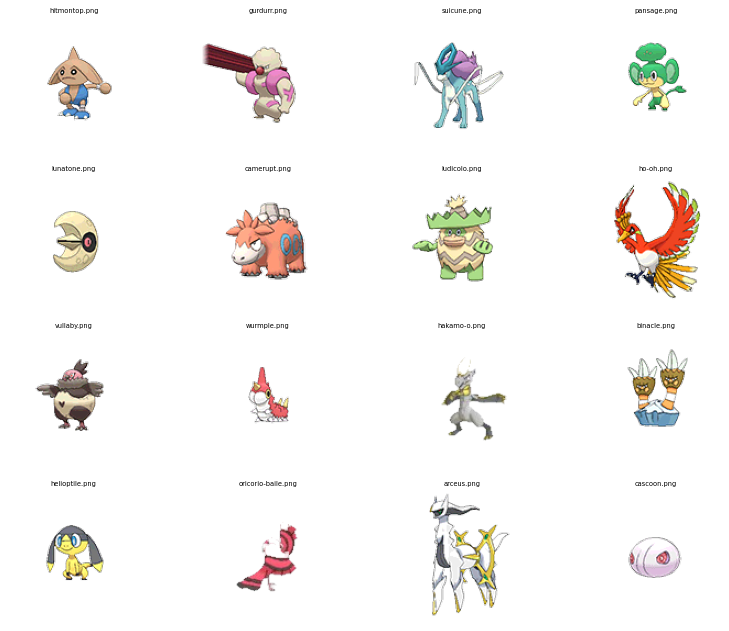

In [11]:
ROWS = 4
COLS = 4
fig = plt.gcf()
fig.set_size_inches(24, 24)
plt.figure(figsize=(12, 10), dpi=80)
for i, img_path in enumerate(full_pic):
    data = img_path.split('/')[-1]
    sp = plt.subplot(ROWS, COLS, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    sp.set_title(data, fontsize=6)
    plt.imshow(img, cmap='gray')
plt.show()

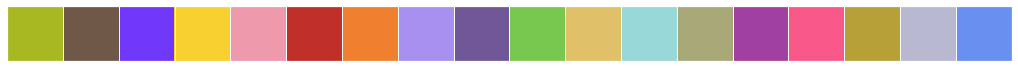

In [12]:
custom_colors = {
    'Bug': '#a8b820',
    'Dark': '#705848',
    'Dragon': '#7038f8',
    'Electric': '#f8d030',
    'Fairy': '#ee99ac',
    'Fighting': '#c03028',
    'Fire': '#f08030',
    'Flying': '#a890f0', 
    'Ghost': '#705898',
    'Grass': '#78c850',
    'Ground': '#e0c068',
    'Ice': '#98d8d8',
    'Normal': '#a8a878',
    'Poison': '#a040a0',
    'Psychic': '#f85888',
    'Rock': '#b8a038',
    'Steel': '#b8b8d0',
    'Water': '#6890f0'
}

sns.set(font_scale=1.25) 
sns.set_palette(sns.color_palette(custom_colors.values()))
sns.palplot(sns.color_palette(custom_colors.values()),size=1)

In [18]:
import glob
# All files ending with .png
pokes_train = list(glob.glob("Práctica 2/train/*/*.png"))
pokes_test = list(glob.glob("Práctica 2/test/*/*.png"))

pokes = pokes_test + pokes_train
names = [os.path.split(x)[1] for x in pokes]

image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(pokes, name='Filepath').astype(str)], axis=1)
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))

label_df = pd.read_csv('dataset/pokemon.csv')

# merge image_df with label_df
df = image_df.merge(label_df, on='Name')

# drop the Name and Type2 columns
df = df.drop(['Name', 'Type2'], axis=1) 
df.head()

,Filepath,Type1
0,Práctica 2/test/Ghost/kricketot.png,Bug
1,Práctica 2/test/Ghost/octillery.png,Water
2,Práctica 2/test/Ghost/pelipper.png,Water
3,Práctica 2/test/Ghost/beldum.png,Steel
4,Práctica 2/test/Ghost/gogoat.png,Grass


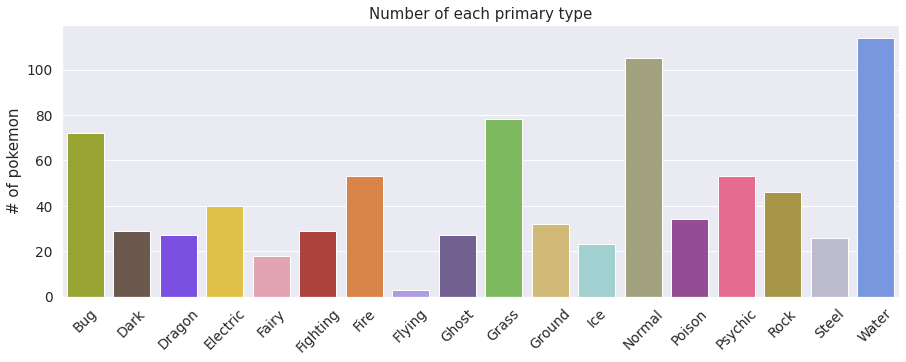

In [19]:
# find the number of each type of pokemon 
type1 = list(custom_colors.keys())
type1_nums = []
for type in type1:
  type1_nums.append(sum(df['Type1']==type))

type1_data = pd.DataFrame(data=type1_nums, index=type1, columns=['# of pokemon'])

# plot number of each type of pokemon
plt.figure(figsize=(15,5))
plt.title('Number of each primary type')
ax = sns.barplot(x=type1_data.index, y='# of pokemon', data=type1_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

## Visualización de un pokemon por cada tipo.

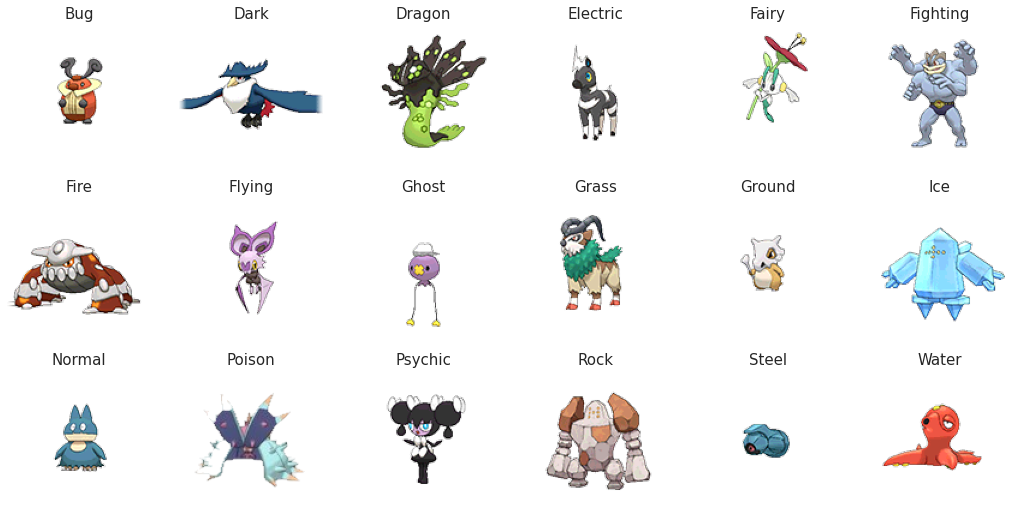

In [20]:

# determine the indices of the first occurrance of each pokemon type
first_row_indices = []
for type in type1:
  first_row_indices.append(df[df['Type1']==type].index[0])

# obtain the image from the filepath at the determined indices
imgs = []
for index in first_row_indices:
  imgs.append(mpimg.imread(df.iat[index, 0]))

# output the images 
f, axarr = plt.subplots(3,6, figsize=(18,9))  
count = 0
for r in range(3):
  for c in range(6):
    axarr[r,c].imshow(imgs[count])
    axarr[r,c].set_title(type1[count])
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()

## pokemon's tipo agua

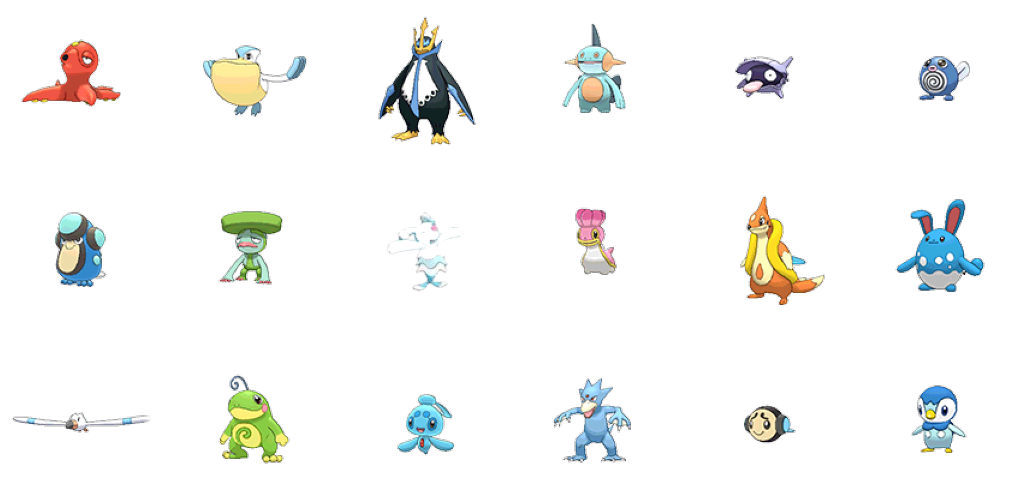

In [21]:
# determine indices
water_indices = []
for i in range(len(df.index)):
  if df.iat[i,1]=='Water':      
    water_indices.append(i)

# obtain images from the filepaths at the determined indices
water_imgs = []
for index in water_indices:
  water_imgs.append(mpimg.imread(df.iat[index, 0]))

# output images
f, axarr = plt.subplots(3,6, figsize=(18,9))  
count = 0
for r in range(3):
  for c in range(6):
    axarr[r,c].imshow(water_imgs[count])
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()

## GENERADORES

In [22]:
dgen_train = ImageDataGenerator(rescale=1./255,
                                validation_split=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

In [23]:
dgen_validation = ImageDataGenerator(rescale=1./255)

In [24]:
dgen_test = ImageDataGenerator(rescale=1./255)

In [25]:
TARGET_SIZE = (200, 200)
BATCH_SIZE = 32
CLASS_MODE = 'categorical'

In [26]:
train_dir

'./Práctica 2/train'

In [27]:
train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=TARGET_SIZE,
                                                 subset='training',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 color_mode='rgba',
                                                 seed=2021)

Found 491 images belonging to 18 classes.


In [28]:
validation_generator = dgen_train.flow_from_directory(train_dir,
                                                      target_size=TARGET_SIZE,
                                                      subset='validation',
                                                      batch_size=BATCH_SIZE,
                                                      class_mode=CLASS_MODE,
                                                      color_mode='rgba',
                                                      seed=2021)

Found 115 images belonging to 18 classes.


In [29]:
test_generator = dgen_test.flow_from_directory(test_dir,
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode=CLASS_MODE,
                                               color_mode='rgba', seed=2021)

Found 203 images belonging to 18 classes.


#### target

In [30]:
train_generator.class_indices

{'Bug': 0,
 'Dark': 1,
 'Dragon': 2,
 'Electric': 3,
 'Fairy': 4,
 'Fighting': 5,
 'Fire': 6,
 'Flying': 7,
 'Ghost': 8,
 'Grass': 9,
 'Ground': 10,
 'Ice': 11,
 'Normal': 12,
 'Poison': 13,
 'Psychic': 14,
 'Rock': 15,
 'Steel': 16,
 'Water': 17}

#### Tamaño de los vectores de entrada

In [31]:
train_generator.image_shape

(200, 200, 4)

## Modelado
### Establecimiento de base

In [32]:
model = Sequential()

### Capas Convolucionales+Pooling

In [33]:
model.add(Conv2D(32, (5,5), padding='same', activation='relu',input_shape=(200, 200, 4)))

model.add(MaxPooling2D(pool_size=(2,2)))

### Dropout

In [34]:
model.add(Dropout(0.2))

### Bloque convolucional

In [35]:
model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

### Capas densamente conectadas

In [36]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(18, activation="softmax"))   #Categorical 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      3232      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 160000)            0

### Parámetros de entrenamiento

In [37]:
model.compile(Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

### Callbacks
#### Early stopping

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

#### Checkpoints

In [39]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                               save_best_only=True,
                               save_weights_only=False,
                               monitor='val_accuracy'
                                 )

### Entrenamiento del modelo

In [40]:
history = model.fit(train_generator,
          epochs=30,
          validation_data=validation_generator,
          callbacks=[early_stopping, checkpoint])

Epoch 1/30
16/16 [==============================] - 28s 2s/step - loss: 2.8304 - accuracy: 0.0998 - val_loss: 2.7651 - val_accuracy: 0.1478
Epoch 2/30
16/16 [==============================] - 29s 2s/step - loss: 2.7289 - accuracy: 0.1405 - val_loss: 2.7309 - val_accuracy: 0.1304
Epoch 3/30
16/16 [==============================] - 29s 2s/step - loss: 2.7141 - accuracy: 0.1589 - val_loss: 2.7345 - val_accuracy: 0.1565
Epoch 4/30
16/16 [==============================] - 32s 2s/step - loss: 2.6875 - accuracy: 0.1609 - val_loss: 2.7326 - val_accuracy: 0.1130
Epoch 5/30
16/16 [==============================] - 31s 2s/step - loss: 2.6663 - accuracy: 0.1772 - val_loss: 2.7334 - val_accuracy: 0.1304
Epoch 6/30
16/16 [==============================] - 29s 2s/step - loss: 2.6612 - accuracy: 0.1772 - val_loss: 2.7408 - val_accuracy: 0.1391
Epoch 7/30
16/16 [==============================] - 29s 2s/step - loss: 2.6423 - accuracy: 0.1548 - val_loss: 2.7512 - val_accuracy: 0.1130
Epoch 8/30
16/16 [==

In [37]:
# get true labels
true_labels = validation_generator.labels

# get predictions in the form of probablities 
predictions = model.predict(val_data)

# convert probablities into binary values 
predictions = [1 if n >= 0.5 else 0 for n in predictions]
print("Model predictions: "+str(predictions))
print("Actual labels:     "+str(true_labels))

# determine filepaths of misclassified pokemon
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred, label, i in zip(predictions, true_labels, range(len(predictions))):
  misclassified_filepaths.append(validation_generator.filepaths[i])
  if pred != label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of misclassified pokemon: "+str(num_misclasssified))

NameError: name 'val_data' is not defined